In [7]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin
from math import pi
L_ = 2.
P_ = 6000.0

h_ = 0.1
b_ = 0.1
E_ = 200000000000.0
c_ = 1
a_ = 0.6
Q = 1000


def M(x):
    if x < a_:
        return P_ * x
    elif (x >= a_) and (x < L_-a_):
        return P_ * a_
    else:
        return P_ * (L_ - x)

def f(x):
    return 12 * M(x) / (E_ * b_ * h_**3)

def u_actual(x):
    if x < a_:
        return (2*P_*x*(x**2-L_**2))/(E_*b_*h_**3)
    elif (x >= a_) and (x < L_-a_):
        return (6*P_*a_*x*(x-L_))/(E_*b_*h_**3)
    else:
        return (2*P_*((L_-x)**3 + L_**2*x - L_**3))/(E_*b_*h_**3)

def find_node(x, x_nodes):
    for i in range(1, len(x_nodes)):
        if x < x_nodes[i]:
            return i-1
    return len(x_nodes)-2

def solve(N):
    x_nodes = np.linspace(0, L_, N+1)
    Le = x_nodes[1] - x_nodes[0]

    K = np.zeros((N+1, N+1))
    for i in range(N):
        K[i][i:i+2] += [1, -1]
        K[i+1][i:i+2] += [-1, 1]
    if N == 5:
        print(x_nodes)
    K /= Le
    K[0][1], K[-1][-2] = 0, 0
    K[0][0], K[-1][-1] = 1, 1
    P = np.zeros((N+1, N+1))
    for i in range(N):
        P[i][i:i+2] += [2, 1]
        P[i+1][i:i+2] += [1, 2]

    P *= -Le / 6
    P[0][0:2] = [0, 0]
    P[-1][-2:] = [0, 0]
    if N == 5:
        print(f(0.4))
    P = np.dot(P, [f(interval) for interval in x_nodes])
    if N == 5:
        print(P)
    u_coeffs = np.linalg.solve(K, P)
    if N==5:
      print(u_coeffs)
    return x_nodes, u_coeffs, K

def approx(x, x_nodes, u_coeffs):
    dx = x_nodes[1] - x_nodes[0]
    output = np.zeros(len(x))
    for i in range(len(x)):
        k = find_node(x[i], x_nodes)
        a0 = (u_coeffs[k] * x_nodes[k+1] - u_coeffs[k+1] * x_nodes[k])/dx
        a1 = (u_coeffs[k] - u_coeffs[k+1])/-dx
        output[i] = a0 + a1*x[i] #(7)
    return output


def relative_errors(x_nodes, u_coeffs):
    x = np.linspace(0, L_, Q)
    u_h = np.array(approx(x, x_nodes, u_coeffs))
    u_ex = np.array([u_actual(i) for i in x])

    up_max = np.max(np.abs(u_ex - u_h))
    low_max = np.max(np.abs(u_ex))
    Er = up_max / low_max

    dx = x[1] - x[0]
    up_sum = np.sum((u_ex - u_h)**2*dx)
    low_sum = np.sum(u_ex**2*dx)
    ErL2 = np.sqrt(up_sum/low_sum)

    return Er, ErL2

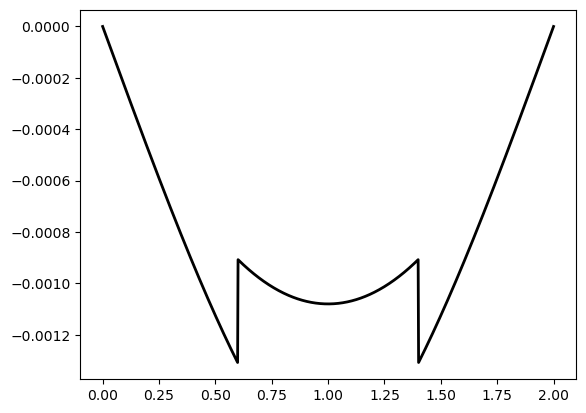

In [8]:
# Plot analytical solution
x = np.linspace(0, L_, Q)
u = [u_actual(i) for i in x]
plt.plot(x, u, label='Analytical solution', color='black', linewidth=2)

[0.  0.4 0.8 1.2 1.6 2. ]
0.0014399999999999997
[ 0.       -0.000528 -0.000816 -0.000816 -0.000528  0.      ]
[-0.        -0.0005376 -0.000864  -0.000864  -0.0005376  0.       ]
[[ 1.   0.   0.   0.   0.   0. ]
 [-2.5  5.  -2.5  0.   0.   0. ]
 [ 0.  -2.5  5.  -2.5  0.   0. ]
 [ 0.   0.  -2.5  5.  -2.5  0. ]
 [ 0.   0.   0.  -2.5  5.  -2.5]
 [ 0.   0.   0.   0.   0.   1. ]]
5 0.46507098790671386 0.3346424197124657
10 0.4066099650901795 0.2882825190764751
20 0.406513534158362 0.2844968452246389
40 0.40646049714586485 0.28354362529512744
80 0.40643277325297067 0.28330484690079005
160 0.4064186099599123 0.283245108985766
320 0.40641145297681563 0.28323018429515495
N	Er	order	ErL2	cond

5	4.65e-01	1.58e+00	3.35e-01	1.78e+01

10	4.07e-01	2.15e-01	2.88e-01	5.85e+01

20	4.07e-01	1.91e-02	2.84e-01	2.00e+02

40	4.06e-01	4.84e-03	2.84e-01	7.27e+02

80	4.06e-01	1.22e-03	2.83e-01	2.75e+03

160	4.06e-01	3.04e-04	2.83e-01	1.07e+04

320	4.06e-01	7.60e-05	2.83e-01	4.21e+04



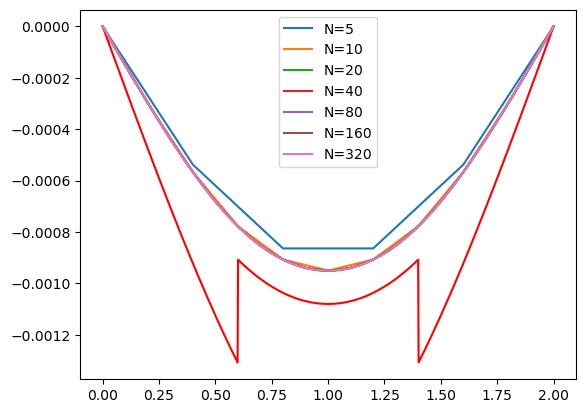

In [9]:
x = np.linspace(0, L_, Q)
plt.plot(x, [u_actual(i) for i in x], 'r')
prevErL2=1
logs = []
for N in [5, 10, 20, 40, 80, 160, 320]:
    x_nodes, u_coeffs, K = solve(N)
    Er, ErL2 = relative_errors(x_nodes, u_coeffs)
    if N != 2:
        plt.plot(x, approx(x, x_nodes, u_coeffs), label=f'N={N}')
        logs.append(f"{N}\t"
                    f"{Er:.2e}\t"
                    f"{np.log2(prevErL2/ErL2):.2e}\t"
                    f"{ErL2:.2e}\t"
                    f"{np.linalg.cond(K):.2e}\n")
    if N == 5:
        print(K)
    print(N, Er, ErL2)
    prevErL2 = ErL2

for line in ['N\tEr\torder\tErL2\tcond\n'] + logs:
    print(line)
plt.legend()
plt.show()